## Анализ сервиса аренды самокатов GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
  
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
  - абонентская плата — 199 рублей в месяц;
  - стоимость одной минуты поездки — 6 рублей;
  - стоимость старта — бесплатно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В первой переменной есть пять колонок: 
1. айди пользователя
2. имя 
3. возраст 
4. город
5. тип подписки

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Во второй переменной четыре колонки:
1. айди пользователя
2. расстояние, которое пользователь проехал за данную сессию
3. продолжительность сессии в минутах
4. дата поездки

In [7]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Третья переменная нам даёт данные о том, какие бывают подписки, поэтому в ней всего две строки и четыре столбца. Подписка "free" предполагает 8 рублей за минуту поездки со стартом поездки 50 рублей (ежемесячного платежа нет). При подписке "ultra" пользователь платит 6 рублей за минуту поездки, старт бесплатный, но ежемесячный платёж 199 рублей.

#### Шаг 2. Предобработка данных

Единственный столбец, в котором нужно поменять формат, это "date" в переменной "rides".

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')

In [9]:
rides.date.head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Добавим номер месяца в переменную "rides" номер месяца, в которой была определённая поездка.

In [10]:
rides['month'] = rides['date'].dt.month

In [11]:
rides.month.head()

0    1
1    1
2    4
3    8
4    8
Name: month, dtype: int64

При загрузке данных мы применяли метод "info", благодаря чему можем утверждать, что пропущенных значений нет. Осталось проверить данные на дубликаты.

In [12]:
users.duplicated().sum()

31

In [13]:
users.drop_duplicates(inplace=True)

In [14]:
users.duplicated().sum()

0

In [15]:
rides.duplicated().sum()

0

В рамках предобработки мы поменяли формат столбца "date" на формат даты, добавили столбец с месяцем, а также проверили данные на дубликаты, которые убрали, и убедились в том, что пропущенных данных нет.

#### Шаг 3. Исследовательский анализ данных

В рамках исследовательского анализа данных нам требуется описать и визуализировать следующие данные:
1. частота встречаемости городов;
2. соотношение пользователей с подпиской и без подписки;
3. возраст пользователей;
4. расстояние, которое пользователь преодолел за одну поездку;
5. продолжительность поездок.

##### Частота встречаемости городов

In [16]:
#создаём переменную с количеством упоминаний каждого города
cities_frequency = users['city'].value_counts()
cities_frequency

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [17]:
#находим какую долю от бщего числа сосатвляет каждый город, 
#записываем эти данные в ранее созданную переменную
cities_frequency = round(cities_frequency / cities_frequency.sum(), 2) * 100
cities_frequency

Пятигорск         14.0
Екатеринбург      13.0
Ростов-на-Дону    13.0
Краснодар         13.0
Сочи              12.0
Омск              12.0
Тюмень            12.0
Москва            11.0
Name: city, dtype: float64

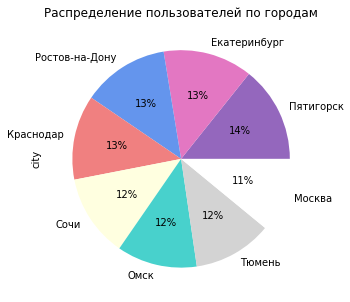

In [18]:
users['city'].value_counts().plot(
    kind = 'pie', 
    y = cities_frequency,
    autopct = '%1.0f%%',
    figsize = (5, 5), 
    colors = ['tab:purple', 'tab:pink', 'cornflowerblue', 'lightcoral', 'lightyellow', 'mediumturquoise', 'lightgrey', 'w'],
    title = 'Распределение пользователей по городам');

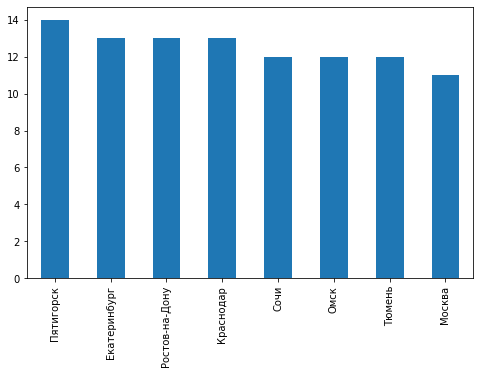

In [19]:
(cities_frequency
    .sort_values(ascending=False)
    .plot(y='count', kind='bar', figsize=(8, 5))
);

Больше всего пользователей из Пятигорска, меньше всего - из Москвы. Но, на самом деле, разница между распределением городов небольшая.

##### Соотношение пользователей с подпиской и без подписки

In [20]:
sub_count = users['subscription_type'].value_counts()
sub_count

free     835
ultra    699
Name: subscription_type, dtype: int64

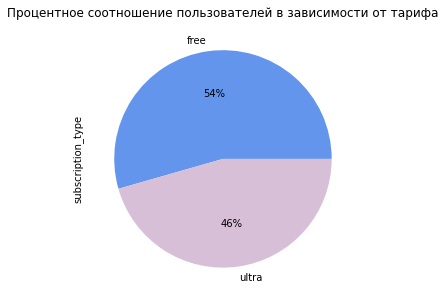

In [21]:
users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = sub_count, 
    autopct = '%1.0f%%', 
    figsize = (5, 5),
    colors = ['cornflowerblue', 'thistle'],
    title = 'Процентное соотношение пользователей в зависимости от тарифа');

Пользователей, которые пользуются сервисом бесплатно, немного больше половины, всего - 54%. Пользователей с подпиской - 46%.

##### Возраст пользователей

In [22]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [23]:
users_age = users['age'].value_counts().sort_values(ascending=False)
users_age

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

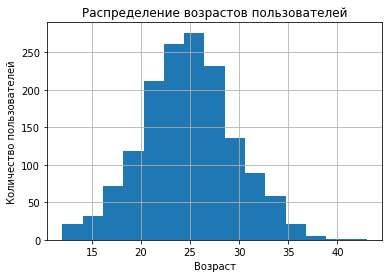

In [24]:
plt.hist(users['age'], bins = 15)
plt.title('Распределение возрастов пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

По данным выше можно утверждать, что больше всего сервисом пользуются люди от 20 до 30 лет. Минимальный возраст - 12 лет, максимальный - 43.

##### Расстояние, которое пользователь преодолел за одну поездку

In [25]:
#самые короткие дистанции за одну сессию
round(rides['distance'].sort_values(), 1).head(10)

11555     0.9
9541      2.6
13690     4.3
8658      6.8
7841      7.1
8906     11.3
8324     12.2
13940    15.0
15626    15.4
11862    15.6
Name: distance, dtype: float64

In [26]:
#самые длинные дистанции за одну сессию
round(rides['distance'].sort_values(ascending=False), 1).head(10)

16309    7211.0
16484    7066.0
15580    6908.5
17171    6760.9
17242    6724.9
10341    6672.0
11385    6601.2
12086    6538.9
10915    6535.4
11319    6503.6
Name: distance, dtype: float64

In [27]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

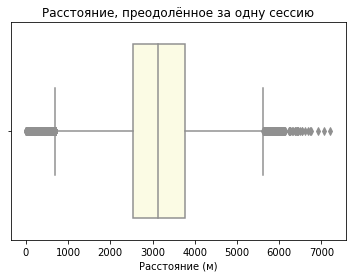

In [28]:
sns.boxplot(
    x=rides['distance'], 
    color='lightyellow')

plt.title('Расстояние, преодолённое за одну сессию')
plt.xlabel('Расстояние (м)');

Посмотрев на данные, можно сказать, что в среднем пользователи за одну сессию проезжают около 3100 м. Есть значения больше 5700 м и меньше 800 м, но их можно отнести к выбросам. В среднем пользователи проезжают от 2600 м до 3800 м.

##### Продолжительность поездок

In [29]:
#самые короткие поездки
rides['duration'].sort_values().head(10)

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
15015    0.5
13012    0.5
7508     0.5
16589    0.5
9049     0.5
Name: duration, dtype: float64

In [30]:
#самые длинные поездки
rides['duration'].sort_values(ascending=False).head(10)

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
143     38.125729
3729    37.014141
499     36.906491
6348    36.809310
4653    36.622595
Name: duration, dtype: float64

In [31]:
#общее время и дистанция для каждого пользователя
rides.groupby(['user_id']).sum(numeric_only = True)

,distance,duration,month
user_id,,,
1,34070.182066,204.604909,99
2,33964.058614,197.644279,67
3,36907.597866,233.193513,66
4,44837.189916,288.563581,107
5,35556.949649,174.073932,51
...,...,...,...
1530,46758.469822,292.366839,104
1531,67054.794222,408.192206,142
1532,33902.203192,212.160144,111


In [32]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Text(0.5, 0, 'Время (мин)')

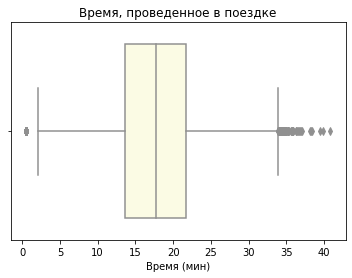

In [33]:
sns.boxplot(
    x=rides['duration'], 
    color='lightyellow')

plt.title('Время, проведенное в поездке')
plt.xlabel('Время (мин)')

В среднем на одну поездку пользователи тратят около 17 минут. Значения больше 35 минут и меньше 2 минут являются выбросами. Обычные поездки в ходят в рамки 14 и 22 минут.

#### Шаг 4. Объединение данных

Соединим данные трёх датасетов из переменных "users", "rides" и "subs".

In [34]:
full_df = users.merge(rides)
full_df = full_df.merge(subs)
full_df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [35]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


В датафрейме с данными пользователей меньше строк, так как каждый пользователь может совершить более одной поездки, поэтому в сборной таблице должно быть столько же строк, сколько и в датафрейме с поездками. Проверим, нету ли пропущенных значений в итоговом датафрейме.

In [36]:
full_df.duplicated().sum()

0

Пропусков нет, можем идти дальше.

Из получившегося датафрейма создадим ещё два: с пользователями с подпиской и без неё.

In [37]:
free_df = full_df[full_df['subscription_type'] == 'free']
free_df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [38]:
ultra_df = full_df[full_df['subscription_type'] == 'ultra']
ultra_df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

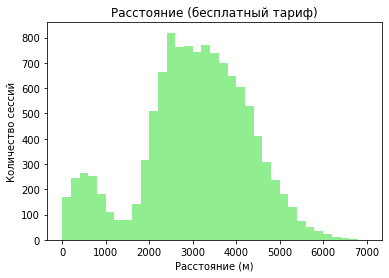

<Figure size 2160x2160 with 0 Axes>

In [39]:
plt.hist(
    free_df['distance'], 
    bins=35, 
    range = (0, 7000),
    color = 'lightgreen'
)

plt.title('Расстояние (бесплатный тариф)')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество сессий')
plt.figure(figsize=(30, 30))
plt.show()

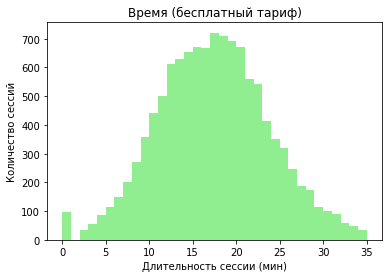

<Figure size 2160x2160 with 0 Axes>

In [40]:
plt.hist(
    free_df['duration'], 
    bins=35, 
    range = (0, 35),
    color = 'lightgreen'
)

plt.title('Время (бесплатный тариф)')
plt.xlabel('Длительность сессии (мин)')
plt.ylabel('Количество сессий')
plt.figure(figsize=(30, 30))
plt.show()

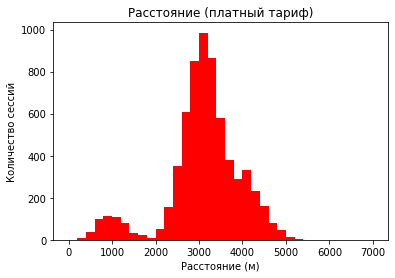

<Figure size 2160x2160 with 0 Axes>

In [41]:
plt.hist(
    ultra_df['distance'], 
    bins=35, 
    range = (0, 7000),
    color = 'red'
)

plt.title('Расстояние (платный тариф)')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество сессий')
plt.figure(figsize=(30, 30))
plt.show()

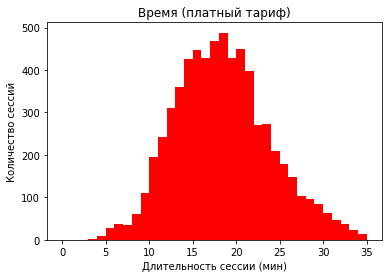

<Figure size 2160x2160 with 0 Axes>

In [42]:
plt.hist(
    ultra_df['duration'], 
    bins=35, 
    range = (0, 35),
    color = 'red'
)

plt.title('Время (платный тариф)')
plt.xlabel('Длительность сессии (мин)')
plt.ylabel('Количество сессий')
plt.figure(figsize=(30, 30))
plt.show()

В рамках данного блока мы объединили все данные в олин датафрейм, а также выделили в отдельные датафреймы данные о пользователях с подпиской и без нее.
  
Визуализировав данные о пользователях с подпиской и без неё, можно сделать некоторые выводы. В целом пользователи с бесплатной подпиской проезжают больше и тратят больше времени на поездки, чем пользователи с платной подпиской. Пользователи с бесплатной подпиской в среднем проезжают от 2 км до 5 км и тратят на это от 10 до 30 мин, в то время как пользователи с платной подпиской проезжают от 2,5 км до 4 км и тратят на это от 13 до 23 минут.

#### Шаг 5. Подсчёт выручки

Найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц и сохраним это в отдельный датафрейм.

In [43]:
total_inf_df = pd.pivot_table(full_df,
                           index = ['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})

total_inf_df.rename(columns = {'name' : 'count'}, inplace = True)
total_inf_df['duration'] = np.ceil(total_inf_df['duration'])

In [44]:
total_inf_df.sort_values(by='month').head(10)

distance  duration  count subscription_type
month user_id                                                 
1     1         7027.511294      42.0      2             ultra
      1061     12637.249630      42.0      3              free
      1063      3276.362299      10.0      1              free
      1064      5297.324649      15.0      1              free
      1065     14547.099333      97.0      4              free
      1066      2809.064949      19.0      1              free
      1067      3864.900780      22.0      1              free
      1069      7007.076943      51.0      3              free
      1071      3635.094136      15.0      1              free
      1072      2498.615999      11.0      1              free

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [45]:
def profit(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count']
    else:
        return 'Такой подписки не существует'

In [46]:
total_inf_df['profit_per_month'] = total_inf_df.apply(profit, axis=1)
total_inf_df.head(10)

distance  duration  count subscription_type  \
month user_id                                                   
1     1        7027.511294      42.0      2             ultra   
      3        3061.777147      13.0      1             ultra   
      5        3914.646990      13.0      1             ultra   
      7        6478.080979      28.0      2             ultra   
      12       3577.151148      33.0      1             ultra   
      13       6687.987446      42.0      2             ultra   
      14       7699.643820      34.0      2             ultra   
      15       4187.621459      39.0      1             ultra   
      20       3516.719208      29.0      1             ultra   
      22       3058.692225      13.0      1             ultra   

               profit_per_month  
month user_id                    
1     1                   451.0  
      3                   277.0  
      5                   277.0  
      7                   367.0  
      12                  397.0  
      13                  451.0  
      14                  403.0  
      15                  433.0  
      20                  373.0  
      22                  277.0

In [47]:
total_inf_df.query('user_id == 5')

,,distance,duration,count,subscription_type,profit_per_month
month,user_id,,,,,
1,5,3914.646990,13.0,1,ultra,277.0
2,5,2561.108241,12.0,1,ultra,271.0
3,5,10633.732186,56.0,3,ultra,535.0
4,5,3373.080412,15.0,1,ultra,289.0
5,5,5823.074031,32.0,2,ultra,391.0
7,5,3311.974724,12.0,1,ultra,271.0
8,5,2720.817111,18.0,1,ultra,307.0
10,5,3218.515955,20.0,1,ultra,319.0


Проверим, есть ли пользвоатели, у которых нет подписки (такого не должно быть, но всякий случай проверить стоит).

In [48]:
total_inf_df.query('profit_per_month == "Такой подписки не существует"')

,,distance,duration,count,subscription_type,profit_per_month
month,user_id,,,,,


#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

*Гипотеза*: пользователи с подпиской тратят больше времени на поездки.
  
*Нулевая гипотеза (Н0)*: пользователи с подпиской тратят столько же времени на поездки, сколько на них тратят пользователи без подписки (время ultra = время free)
  
*Альтернативная гипотеза (Н1)*: пользователи с подпиской тратят больше времени на поездки, в сравнении с пользователями без подписки (время ultra > время free)

In [49]:
ultra = ultra_df['duration'] 

free = free_df['duration']

results = st.ttest_ind(ultra, free, alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что пользователи с платной подпиской тратят столько же времени, как и пользователи без подписки.

##### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

*Гипотеза*: расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
  
*Нулевая гипотеза (Н0)*: расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров (расстояние ultra = 3130)
  
*Альтернативная гипотеза (Н1)*: расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров (расстояние ultra < 3130)

In [50]:
ultra_distance = ultra_df['distance']

interested_value = 3130

alpha = .05

results = st.ttest_1samp(ultra_distance, interested_value, alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Мы не можем отвергнуть то, что расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

*Гипотеза*: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
  
*Нулевая гипотеза (Н0)*: помесячная выручка от пользователей с подпиской по месяцам такая же, как и выручка от пользователей без подписки (выручка ultra = выручка free)
  
*Альтернативная гипотеза (Н1)*: помесячная выручка от пользователей с подпиской по месяцам больше, чем выручка от пользователей без подписки (выручка ultra > выручка free)

In [51]:
ultra_month = total_inf_df.loc[total_inf_df.subscription_type == 'ultra', 'profit_per_month'] 

free_month = total_inf_df.loc[total_inf_df.subscription_type == 'free', 'profit_per_month'] 


results = st.ttest_ind(ultra_month, free_month, alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

2.8130926188487286e-35
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам такая же, как и выручка от пользователей без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


Так как у нас есть данные до и после обновления, следует использовать гипотезу о равенстве средних для зависимых (парных) выборок.
  
Гипотезы в таком случае будут сформулированы так:
  
H0 : μ1 = μ2  
H1 : μ1 != μ2  
  
где μ1 и μ2 - средние значения количество обращений в техподдержку до и после обновления.
  
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяется метод scipy.stats.ttest_rel( ).

#### Шаг 7. Общий вывод

Мы загрузили три датасета с данными о пользователях, их поездках и данными о видах подписок.  
  
В рамках предобработки мы поменяли формат столбца "date" на формат даты, добавили столбец с месяцем, а также проверили данные на дубликаты, которые убрали, и убедились в том, что пропущенных данных нет.  
  
В рамказ исследовательского анализа данных мы узнали, что:
1. Больше всего пользователей из Пятигорска, меньше всего - из Москвы. Но, на самом деле, разница между распределением городов небольшая.
2. Пользователей, которые пользуются сервисом бесплатно, немного больше половины, всего - 54%. Пользователей с подпиской - 46%.
3. Больше всего сервисом пользуются люди от 20 до 30 лет. Минимальный возраст - 12 лет, максимальный - 43.
4. в среднем пользователи за одну сессию проезжают около 3100 м. Есть значения больше 5700 м и меньше 800 м, но их можно отнести к выбросам. В среднем пользователи проезжают от 2600 м до 3800 м.
5. В среднем на одну поездку пользователи тратят около 17 минут. Значения больше 35 минут и меньше 2 минут являются выбросами. Обычные поездки в ходят в рамки 14 и 22 минут.
  
В рамках следующего блока мы объединили все данные в один датафрейм, а также выделили в отдельные датафреймы данные о пользователях с подпиской и без нее.
  
Визуализировав данные о пользователях с подпиской и без неё, можно сделать некоторые выводы. В целом пользователи с бесплатной подпиской проезжают больше и тратят больше времени на поездки, чем пользователи с платной подпиской. Пользователи с бесплатной подпиской в среднем проезжают от 2 км до 5 км и тратят на это от 10 до 30 мин, в то время как пользователи с платной подпиской проезжают от 2,5 км до 4 км и тратят на это от 13 до 23 минут.
  
Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм, а также добавили в него столбец с помесячной выручкой.
  
Проверили гипотезы:
  
1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе (отвергли нулевую гипотезу).  
2. Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку (нет оснований отвергнуть нулевую гипотезу).  
3. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки (отвергли нулевую гипотезу).